# Analisis Bisnis Y.Afisha

Anda berhasil menunjukkan kinerja yang cemerlang selama mengikuti kursus Practicum, dan Anda pun ditawarkan kesempatan untuk menjalani program magang di departemen analitik perusahaan Y.Afisha. Tugas pertama yang mereka berikan kepada Anda adalah membantu mengoptimalkan anggaran biaya pemasaran.

## Deskripsi Proyek

Proyek ini berfokus pada analisis bisnis. Data yang dimiliki yaitu Log/catatan server yang memuat data kunjungan ke situs Y.Afisha dari bulan Januari 2017 hingga bulan Desember 2018, file dump yang memuat semua pesanan untuk periode tersebut, serta statistik biaya pemasaran.

## Tujuan

1. Menganalisis para pengguna dalam menggunakan produk Y.Afisha.
2. Mengidentifikasi kapan para pengguna mulai melakukan pembelian.
3. Menghitung jumlah uang yang disumbangkan oleh setiap pengguna.
4. Mengidentifikasi kapan semua biaya pemasaran terbayarkan.

### Tahapan

Data proyek analisis bisnis ini disimpan dalam file:
* `/datasets/costs_us.csv`
* `/datasets/orders_log_us.csv`
* `/datasets/visits_log_us.csv`

Proyek ini terdiri dari dua tahap:

1. Pra-pemrosesan Data
2. Analisis Data Exploratif (EDA)

## 1. Pra-pemrosesan Data

In [1]:
# Import library
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import numpy as np
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

import datetime as dt
import matplotlib.ticker as ticker

### 1.1. Memuat Data

In [2]:
# Try and except datasets
try:
    data_visits = pd.read_csv('visits_log_us.csv')
    data_orders = pd.read_csv('orders_log_us.csv')
    data_costs = pd.read_csv('costs_us.csv')
except:
    data_visits = pd.read_csv('/datasets/visits_log_us.csv')
    data_orders = pd.read_csv('/datasets/orders_log_us.csv')
    data_costs = pd.read_csv('/datasets/costs_us.csv')

### 1.2. Mengeksplorasi Data Awal

#### **Data Visits** (log/catatan server yang memuat data kunjungan ke situs web)

In [3]:
data_visits

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


**Deskripsi data_visits**: 

- `Uid` — ID pengguna
- `Device` — perangkat pengguna
- `Start Ts` — tanggal dan waktu dimulainya sesi
- `End Ts`  — tanggal dan waktu berakhirnya sesi
- `Source Id` — ID sumber iklan, sumber yang digunakan pengguna untuk datang ke situs web

Semua tanggal dalam tabel ini menggunakan format YYYY-MM-DD

In [4]:
# Check data info
data_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
data_visits['Device'].unique()

array(['touch', 'desktop'], dtype=object)

In [6]:
# Check total missing values descending
data_visits.isna().sum().sort_values(ascending=False)

Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

In [7]:
# Check duplicated data
data_visits.duplicated().sum()

0

In [8]:
# Check anomaly timestamp
time_check = data_visits.query("`End Ts` < `Start Ts`")
time_check

,Device,End Ts,Source Id,Start Ts,Uid
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


**Kesimpulan sementara:**

* Tabel `data_visits` memiliki tabel nama yang cukup berantakan. Terdapat campuran huruf besar dan spasi diantara kata.
* Tabel `data_visits` memiliki memory usage yang cukup besar. Kemungkinan disebabkan oleh tabel date/time yang tidak tersimpan secara optimal.
* Kolom `Device` memiliki jumlah kolom kategori yang sedikit.
* Tidak terdapat nilai yang hilang.
* Tabel `data_visits` tidak memiliki nilai duplikat pada data.
* Terdapat anomali data ketika Start Ts melebihi End Ts.

#### **Data Orders** (data terkait pesanan)

In [9]:
data_orders

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


**Deskripsi data_orders**: 

- `Uid` — ID pengguna yang membuat pesanan
- `Buy Ts` — tanggal dan waktu pesanan dibuat
- `Revenue` — pendapatan Y.Afisha dari pesanan tersebut

In [10]:
# Check data info
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [11]:
# Check statistics data
data_orders.describe()

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


In [12]:
# Check duplicated data
data_orders.duplicated().sum()

0

In [13]:
# Check duplicated data
data_orders.duplicated().sum()

0

**Kesimpulan sementara:**

* Tabel `data_orders` memiliki tabel nama yang cukup berantakan. Terdapat campuran huruf besar pada kata.
* Tabel `data_orders` terdapat nilai anomali pada kolom `Revenue`, nilai ini perlu dianalisa dampak terdapat keseluruhan data.
* Tidak terdapat nilai yang hilang.
* Tabel `data_orders` tidak memiliki nilai duplikat pada data.

#### **Data Costs** (data terkait pengeluaran pemasaran):

In [14]:
data_costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


**Deskripsi data_costs**: 

- `source_id` — ID sumber iklan
- `dt` — tanggal
- `costs` — pengeluaran untuk sumber iklan pada tanggal tersebut

In [15]:
# Check data info
data_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [16]:
# Check statistics data
data_costs.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


In [17]:
# Check total missing values descending
data_costs.isna().sum().sort_values(ascending=False)

source_id    0
dt           0
costs        0
dtype: int64

In [18]:
# Check duplicated data
data_costs.duplicated().sum()

0

**Kesimpulan sementara:**

* Tabel `data_costs` sudah memiliki penulisan kolom dengan rapih.
* Kolom `costs` perlu diperiksa apakah tidak memiliki anomali data.
* Tidak terdapat nilai hilang.
* Tabel `data_costs` tidak memiliki nilai duplikat pada data.

### Kesimpulan dan Langkah-Langkah Selanjutnya

#### **Nilai yang Hilang**

Untuk mengoptimalkan data yang dimiliki untuk keperluan analisis, pastikan setiap kolomnya disajikan dalam tipe data yang benar. Langkah pertama yaitu memeriksa nilai yang hilang dalam data:

* Nilai yang hilang tidak ditemukan di setiap tabel. Proses pengisian nilai hilang dapat dilanjutkan ke tahap selanjutnya.

#### **Gaya Penulisan**

Setelah mengatasi nilai-nilai yang hilang, langkah selanjutnya yaitu merapihkan data:

* Mengoptimalkan memory dengan mengubah format object pada kolom tanggal di ketiga tabel. Yaitu kolom `Start Ts`, `End Ts`, `Buy Ts`, dan `dt` menjadi Datetime objects.
* Tedapat kolom dengan kategori yang sedikit yaitu kolom `Device`. Kolom tersebut dapat dioptimasi dengan mengubah menjadi tipe yang sesuai.
* Pada tabel `data_visits` dan tabel `data_orders` perlu diubah format penulisan kolom menjadi huruf kecil serta spasi akan diubah menjadi underscore (_).


#### **Duplikat**

Setelah mengoptimalkan data serta merapihkannya, selanjutnya memeriksa duplikat pada data: 

* Nilai duplikat tidak ditemukan di setiap tabel pada analisis awal. Proses menghilangkan nilai duplikat dapat dilanjutkan ke tahap selanjutnya.

#### **Anomali Data**

Setelah memeriksa data duplikat perlu memepertimbangkan data anomali karena data tersebut mempengaruhi analisis penelitian. Berikut data anomali yang diperiksa:

* Pada kolom `Revenue` di dalam tabel `data_orders` perlu diperiksa apakah terdapat anomali data atau nilai outlier.
* Pada kolom `costs` di dalam tabel `data_costs` perlu diperiksa apakah terdapat anomali data atau nilai outlier.
* Tedapat anomali pada tabel 'data_visits' yaitu TS yang tidak tepat.

### 1.3. Mengoptimalkan Data

data dioptimalkan menggunakan dtype dan parse_dates

In [19]:
# Try and except datasets
try:
    data_visits = pd.read_csv('visits_log_us.csv', dtype={'Device': 'category'}, parse_dates=['Start Ts', 'End Ts'])
    data_orders = pd.read_csv('orders_log_us.csv', parse_dates=['Buy Ts'])
    data_costs = pd.read_csv('costs_us.csv', parse_dates=['dt'])
except:
    data_visits = pd.read_csv('/datasets/visits_log_us.csv', dtype={'Device': 'category'}, parse_dates=['Start Ts', 'End Ts'])
    data_orders = pd.read_csv('/datasets/orders_log_us.csv', parse_dates=['Buy Ts'])
    data_costs = pd.read_csv('/datasets/costs_us.csv', parse_dates=['dt'])

In [20]:
# Create a tuple from the dataframes.
data = (data_visits, data_orders, data_costs)

# Assign names to the dataframes
data_visits.name = 'visits_log_us'
data_orders.name = 'orders_log_us'
data_costs.name = 'costs_us'

### 1.4. Memperbaiki Penulisan Judul

In [21]:
# Loop for changing column name in every table
for df in data:
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace('\s+', '_', regex=True)

In [22]:
# Print a concise summary of the dataFrames with pandas.DataFrame.info() method.
for df in data:
    print("{}".format(df.name))
    df.info()
    print()

visits_log_us
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  category      
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB

orders_log_us
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB

costs_us
<class 'pandas.core.frame.Data

### 1.5. Memperbaiki Anomali Data

In [23]:
data_visits = data_visits.query("`start_ts` <= `end_ts`").reset_index(drop=True)

In [24]:
data_visits

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359393,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359394,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359395,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359396,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


## 2. Analisis Data Exploratif (EDA)

### 2.1. Memeriksa Data yang Sudah Bersih

In [25]:
for df in data:
    print("{}".format(df.name))
    print(df.head(10))
    print()

visits_log_us
    device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   
5  desktop 2017-09-03 21:36:00          5 2017-09-03 21:35:00   
6  desktop 2018-01-30 12:09:00          1 2018-01-30 11:13:00   
7    touch 2017-11-05 15:15:00          3 2017-11-05 15:14:00   
8  desktop 2017-07-19 10:44:00          3 2017-07-19 10:41:00   
9  desktop 2017-11-08 13:43:00          5 2017-11-08 13:42:00   

                    uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168  
5  16007536194108375387  
6   6661610529277171451  
7  11423865690854540312  
8   2987360259350925644  
9   128924

### 2.2. Menyusun Laporan dan Menghitung Metrik

Dalam menganalisis data ini perlu menjawab beberapa pertanyaan berikut:

1. Produk
    * Berapa jumlah orang yang menggunakan produk setiap hari, minggu, dan bulan?
    * Berapa jumlah sesi per harinya?
    * Berapa lama durasi untuk setiap sesi?
    * Seberapa sering pengguna kembali menggunakan produk?
2. Penjualan
    * Kapan orang-orang mulai melakukan pembelian?
    * Berapa jumlah pesanan yang mereka buat selama periode waktu tertentu?
    * Berapa besaran rata-rata pembeliannya?
    * Berapa jumlah uang yang mereka kontribusikan?
3. Pemasaran
    * Berapa jumlah uang yang dihabiskan? Keseluruhan/per sumber/dari waktu ke waktu?
    * Berapa biaya akuisisi pelanggan dari masing-masing sumber?
    * Seberapa menguntungkannya investasi tersebut?

#### 2.2.1. Product Analysis

##### a. Berapa jumlah orang yang menggunakan produk setiap hari, minggu, dan bulan?

In [26]:
# Analysis data_visits
data_visits['visits_year']  = data_visits['start_ts'].dt.year
data_visits['visits_month'] = data_visits['start_ts'].dt.month
data_visits['visits_week']  = data_visits['start_ts'].dt.week
data_visits['visits_date'] = data_visits['start_ts'].dt.date
data_visits.head()

,device,end_ts,source_id,start_ts,uid,visits_year,visits_month,visits_week,visits_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [27]:
dau_total = data_visits.groupby('visits_date').agg({'uid': 'nunique'}).mean()
wau_total = data_visits.groupby(['visits_year', 'visits_week']).agg({'uid': 'nunique'}).mean()
mau_total = data_visits.groupby(['visits_year', 'visits_month']).agg({'uid': 'nunique'}).mean()

print('Average Daily Active (unique) Users :', int(dau_total))
print('Average Weekly Active (unique) Users :',int(wau_total))
print('Average Monthly Active (unique) Users :',int(mau_total)) 

Average Daily Active (unique) Users : 907
Average Weekly Active (unique) Users : 5716
Average Monthly Active (unique) Users : 23228


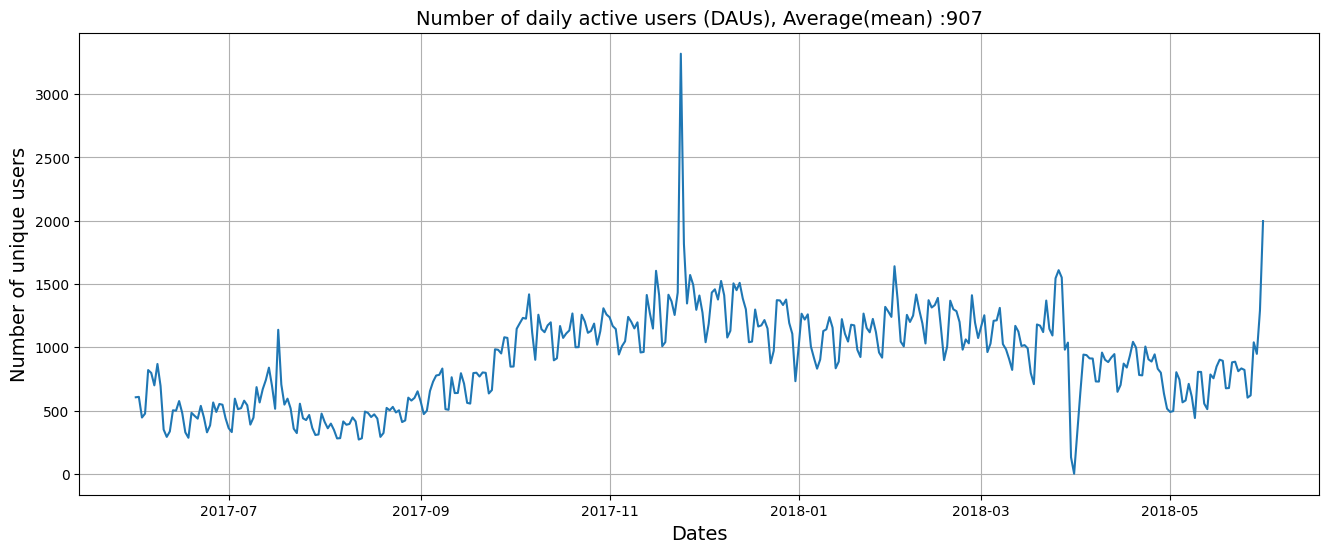

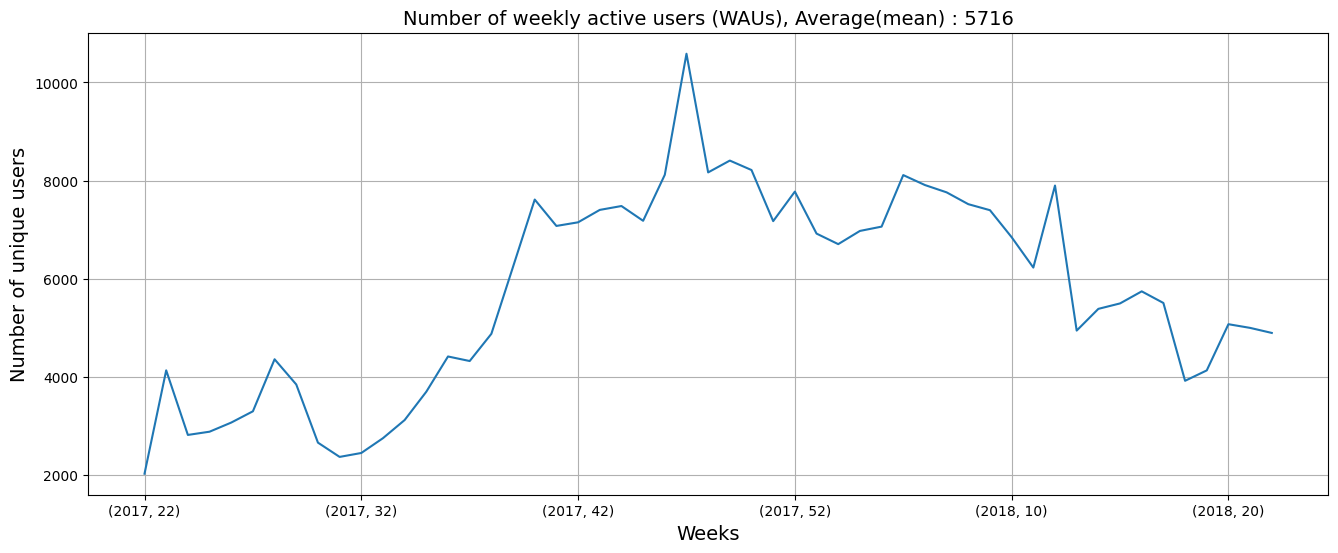

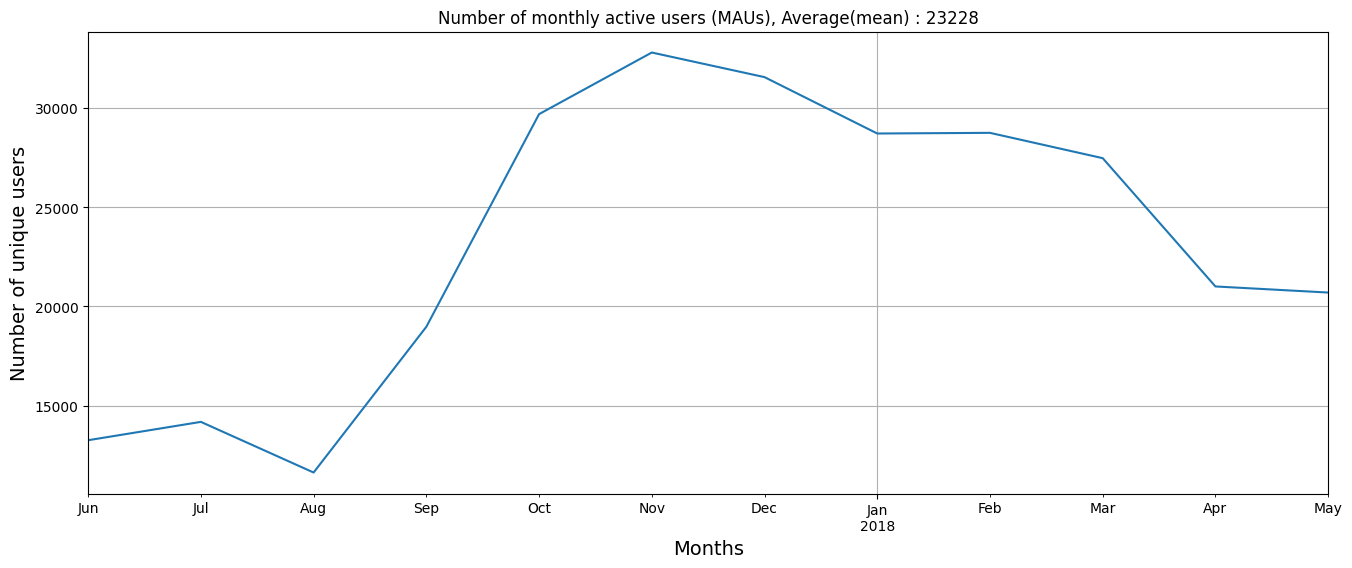

In [28]:
# Plot for daily, weekly and monthly
visits_plot = data_visits.copy()
fig, ax = plt.subplots(figsize=(16,6))
visits_plot.groupby(visits_plot['start_ts'].dt.date)['uid'].nunique().plot()
plt.xlabel("Dates", fontsize=14)
plt.ylabel("Number of unique users", fontsize=14)
plt.title(f"Number of daily active users (DAUs), Average(mean) :{int(round(visits_plot.groupby(visits_plot['start_ts'].dt.date)['uid'].nunique().mean(),2))}", fontsize=14)
plt.grid(True)
plt.show()
fig, ax = plt.subplots(figsize=(16,6))
visits_plot.groupby([visits_plot['start_ts'].dt.year,visits_plot['start_ts'].dt.isocalendar().week])['uid'].nunique().plot()
plt.xlabel("Weeks", fontsize=14)
plt.ylabel("Number of unique users", fontsize=14)
plt.title(f"Number of weekly active users (WAUs), Average(mean) : {int(round(visits_plot.groupby([visits_plot['start_ts'].dt.year,visits_plot['start_ts'].dt.isocalendar().week])['uid'].nunique().mean(),2))}", fontsize=14)
plt.grid(True)
plt.show()
fig, ax = plt.subplots(figsize=(16,6))
visits_plot.groupby(visits_plot['start_ts'].dt.to_period('M'))['uid'].nunique().plot()
plt.xlabel("Months", fontsize=14)
plt.ylabel("Number of unique users", fontsize=14)
plt.title(f"Number of monthly active users (MAUs), Average(mean) : {int(round(visits_plot.groupby(visits_plot['start_ts'].dt.to_period('M'))['uid'].nunique().mean(),2))}")
plt.grid(True)
plt.show()

**Kesimpulan:**

* Jumlah pengguna yang menggunakan produk perhari(DAU) rata-rata sebanyak 907 pengguna. Peningkatan terjadi dari awal Oktober 2017 - akhir Maret 2018.
* Jumlah pengguna yang menggunakan produk perminggu(WAU) rata-rata sebanyak 5716 pengguna. Serupa seperti DAU, WAU mengalami peningkatan dari minggu ke-32 hingga pertengangan minggu akhir tahun(minggu ke-53)
* Jumlah pengguna yang menggunakan produk perbulan(MAU) rata-rata sebanyak 23228 pengguna. Dari plot terlihat bahwa awal mula terjadi peningkatan yaitu pada bulan Agustus 2017 hingga November 2017. Dari November 2017 menuju Maret 2018 pengguna masih aktif dan terhitung banyak.

#### b. Berapa jumlah sesi perharinya?

In [29]:
sessions_per_user = data_visits.groupby('visits_date').agg({'uid': ['count', 'nunique']})

sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = (sessions_per_user['n_sessions'] / sessions_per_user['n_users'])
sessions_per_user

,n_sessions,n_users,sess_per_user
visits_date,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024
...,...,...,...
2018-05-27,672,620,1.083871
2018-05-28,1156,1039,1.112608
2018-05-29,1035,948,1.091772


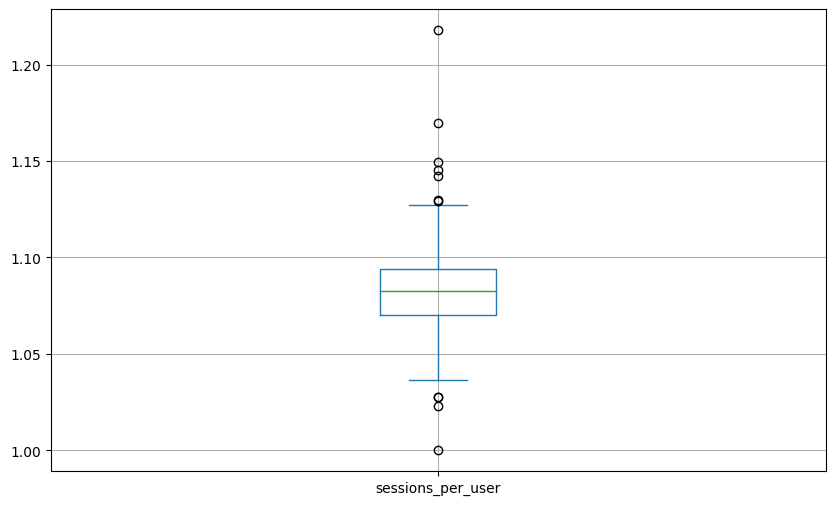

In [30]:
# Boxplot for finding session per day
fig, ax = plt.subplots(figsize=(10,6))
data_visits.groupby([data_visits['start_ts'].dt.date,'uid']).size()\
    .reset_index()\
    .rename(columns={0:'sessions_per_user'})\
    .groupby('start_ts')['sessions_per_user'].mean()\
    .plot(kind='box')
plt.grid(True)
plt.show()

**Kesimpulan:**

* Secara rata-rata dan boxplot, semua pengguna hanya menggunakan 1 sesi setiap hari menggunakan produk. Dengan demikian, kita tidak bisa menyebut bahwa produk ini digunakan secara rutin.

#### c. Berapa lama durasi untuk setiap sesi?

Average session length atau ASL dapat digunakan untuk mengetahui berapa lama durasi setiap sesi.

In [31]:
data_visits['session_duration_sec'] = (data_visits['end_ts'] - data_visits['start_ts']).dt.seconds
data_visits['session_duration_sec'].mean()

643.0422873805642

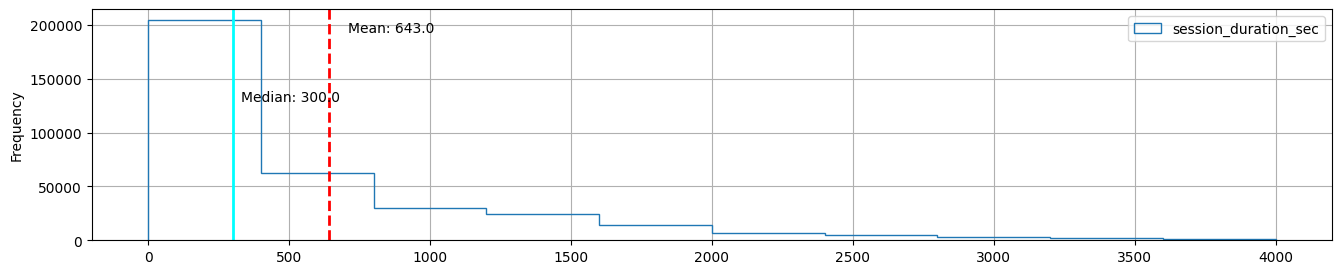

In [32]:
plt.figure(figsize=(16,3))
data_visits['session_duration_sec'].plot(kind='hist', y='session_duration_sec', histtype='step', range=(0, 4000), grid=True, legend=True)
plt.axvline(data_visits['session_duration_sec'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(data_visits['session_duration_sec'].median(), color='cyan', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(data_visits['session_duration_sec'].mean()*1.1, max_ylim*0.9, 
         'Mean: {:.1f}'.format(data_visits['session_duration_sec'].mean()))
plt.text(data_visits['session_duration_sec'].median()*1.1, max_ylim*0.6, 
         'Median: {:.1f}'.format(data_visits['session_duration_sec'].median()))
plt.show()

In [33]:
asl = data_visits['session_duration_sec'].mode()
asl

0    60
Name: session_duration_sec, dtype: int64

**Kesimpulan:**

* Durasi setiap sesi secara per user rata-rata yaitu 643.5 detik (10 menit). Median penggunaan sesi per user terlihat yaitu 300 detik (5 menit).
* Secara ASL, pengguna dalam satu sesi rata-rata menggunakan produk selama 60 detik.

#### d. Seberapa sering pengguna kembali menggunakan produk?

Dapat menggunakan metrik sticky factors. Metrik ini menunjukkan tingkat loyalitas audiens—seberapa sering para pengguna kembali ke menggunakan produk.

In [34]:
# Sticky factors
sticky_wau = dau_total / wau_total * 100
print(sticky_wau)
sticky_mau = dau_total / mau_total * 100
print(sticky_mau)

uid    15.884409
dtype: float64
uid    3.90897
dtype: float64


**Kesimpulan:**

* Dilihat dari perminggu(WAU), pengguna kembali menggunakan produk yaitu sebesar 15%. Sedangkan secara bulanan(MAU) yaitu 3%..

#### 2.2.2. Sales Analysis

#### a. Kapan orang-orang mulai melakukan pembelian?

In [35]:
first_order_dates = data_orders.groupby('uid')['buy_ts'].min()
first_order_dates.name = 'first_order_datetime'

In [36]:
data_orders = data_orders.join(first_order_dates, on='uid')

In [37]:
data_orders['orders_month'] = data_orders['buy_ts'].astype('datetime64[M]')
data_orders['first_order_month'] = data_orders['first_order_datetime'].astype('datetime64[M]')
data_orders.head(10)

,buy_ts,revenue,uid,first_order_datetime,orders_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:10:00,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:25:00,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:27:00,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:29:00,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:58:00,2017-06-01 07:58:00
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00,2017-06-01 08:43:00,2017-06-01 08:43:00
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:54:00,2017-06-01 08:54:00,2017-06-01 08:54:00
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00,2017-06-01 09:22:00,2017-06-01 09:22:00
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01 09:22:00,2017-06-01 09:22:00,2017-06-01 09:22:00
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01 09:23:00,2017-06-01 09:23:00,2017-06-01 09:23:00


In [38]:
first_purchase = pd.DataFrame(
    data_visits.sort_values(by=['uid','start_ts'])\
        .reset_index(drop=True)\
        .groupby('uid')['start_ts'].first()
).join(
    pd.DataFrame(
        data_orders.sort_values(by=['uid','buy_ts'])\
            .reset_index(drop=True)\
            .groupby(['uid'])['buy_ts'].first()
    ),
    how='inner'
)
first_purchase['diff'] = first_purchase['buy_ts'] - first_purchase['start_ts']
first_purchase['diff'].describe()

count                         36523
mean     16 days 21:40:10.550064343
std      47 days 01:44:46.481416776
min                 0 days 00:00:00
25%                 0 days 00:04:00
50%                 0 days 00:16:00
75%                 2 days 00:17:00
max               363 days 07:04:00
Name: diff, dtype: object

In [39]:
f"first purchase in {first_purchase['diff'].median().seconds/60} minutes"

'first purchase in 16.0 minutes'

**Kesimpulan:**

* Rata-rata pengguna membeli produk pertama kali dari awal kunjungan hingga membeli produk yaitu setelah 16 menit. 

#### b. Berapa jumlah pesanan yang mereka buat selama periode waktu tertentu?

In [40]:
# Create cohorts
data_visits['cohort'] = pd.to_datetime(data_visits['start_ts']).dt.to_period('M')
data_visits.head()

,device,end_ts,source_id,start_ts,uid,visits_year,visits_month,visits_week,visits_date,session_duration_sec,cohort
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-05
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,2017-12


In [41]:
user_dict = pd.to_datetime(data_visits.groupby('uid')['start_ts'].min()).dt.to_period('M').to_dict()

In [42]:
data_orders['cohort'] = data_orders['uid'].map(user_dict)

In [43]:
data_orders['year'] = pd.to_datetime(data_orders['buy_ts']).dt.year
data_orders['month'] = pd.to_datetime(data_orders['buy_ts']).dt.month

In [44]:
data_orders['ts'] = data_orders.apply(lambda x: x['month'] - x['cohort'].month if x['year'] == x['cohort'].year else (((x['year'] - x['cohort'].year) * 12) + x['month']) - x['cohort'].month, axis=1)

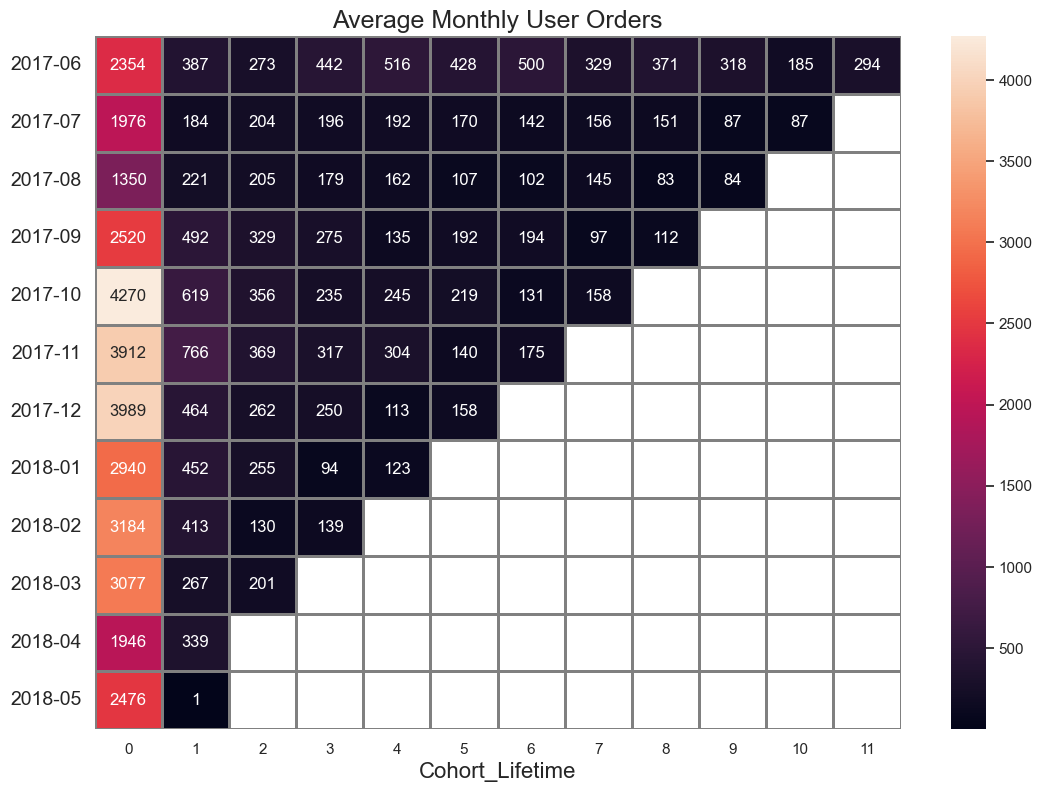

In [45]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Average Monthly User Orders', fontsize=18)
ax = sns.heatmap(data_orders.groupby(['cohort', 'ts']).size().reset_index().pivot(index='cohort', columns='ts', values=0), annot=True, fmt='.0f', linewidths=1, linecolor='gray')
ax.tick_params(axis='y', rotation=0, labelsize=14)
ax.set_xlabel('Cohort_Lifetime', fontsize=16)
ax.set_ylabel('', fontsize=16)
plt.show()

**Kesimpulan:**

* Jumlah pelanggan aktif dalam kohort menurun sangat drastis setelah bulan pertama.
* Di beberapa kohort, jumlah pelanggan aktif terkadang menunjukkan peningkatan (contohnya, kohort 2017-06).

#### c. Berapa besaran rata-rata pembeliannya?

In [46]:
avg_buy = data_orders.groupby(['cohort', 'ts']).agg({'revenue': ['sum', 'count']}).reset_index()
avg_buy['average_revenue'] = avg_buy[('revenue',   'sum')] / avg_buy[('revenue', 'count')]
avg_buy.pivot(index='cohort', columns='ts', values='average_revenue')

ts,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-06,4.060106,6.885220,5.365165,8.783009,7.636802,6.599252,6.979900,6.902158,6.247736,10.948553,11.913568,6.557177
2017-07,4.997414,5.756957,5.435784,5.015102,4.411406,4.694588,4.140845,4.937821,4.798146,6.793448,5.369655,NaN
2017-08,4.618378,4.512760,4.884634,5.286089,5.000247,4.980374,4.771078,8.594690,10.007711,4.472857,NaN,NaN
2017-09,4.903651,7.521301,6.415289,37.959745,9.544296,9.948177,4.983711,5.065773,3.737232,NaN,NaN,NaN
2017-10,4.300309,6.154814,3.727584,4.502340,4.259061,4.667534,4.419160,4.151266,NaN,NaN,NaN,NaN
2017-11,4.225918,3.482480,3.639160,4.320284,3.647171,5.054500,3.992000,NaN,NaN,NaN,NaN,NaN
2017-12,4.225871,3.747909,16.024046,20.495280,12.898850,11.279304,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,3.604425,4.317920,4.567686,3.254043,4.288374,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,3.615776,4.804988,5.101462,6.482086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


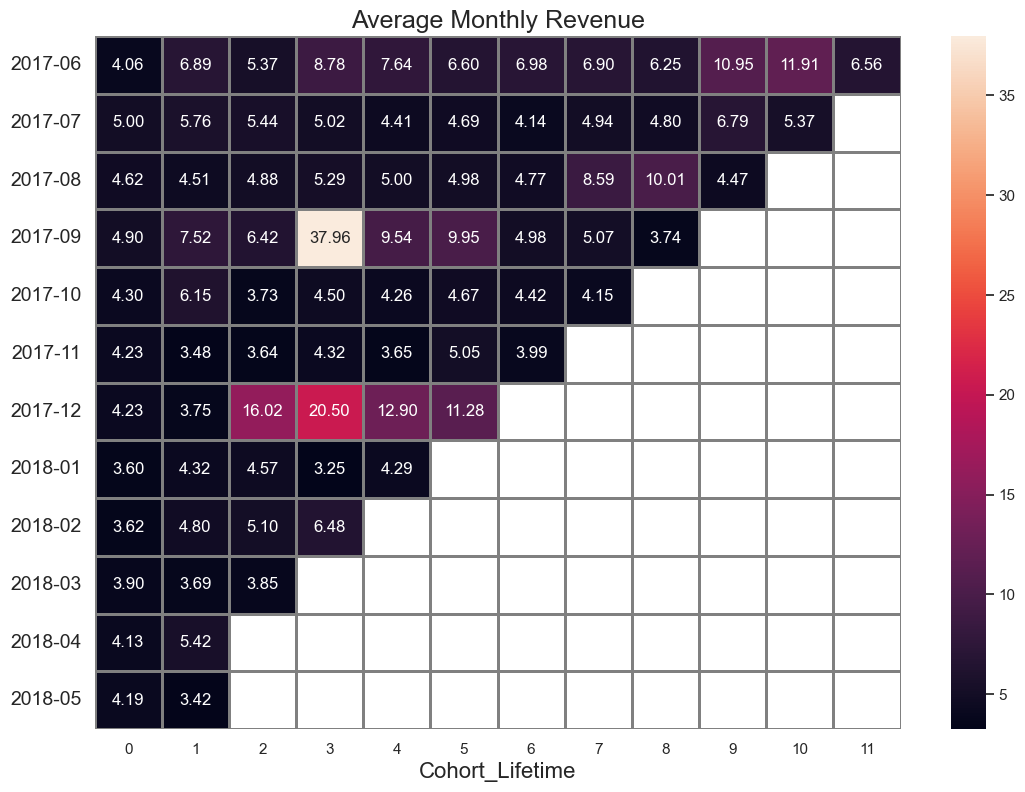

In [47]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Average Monthly Revenue', fontsize=18)
ax = sns.heatmap(avg_buy.pivot(index='cohort', columns='ts', values='average_revenue'), annot=True, fmt='.2f', linewidths=1, linecolor='gray')
ax.tick_params(axis='y', rotation=0, labelsize=14)
ax.set_xlabel('Cohort_Lifetime', fontsize=16)
ax.set_ylabel('', fontsize=16)
plt.show()

**Kesimpulan:**

* Dilihat dari tabel cohort, rata-rata pembelian pada bulan pertama 4% menuju bulan selanjutnya mengalami peningkatan.
* Pada bulan ke 3, cohort pada bulan 09-2017 mengalami peningkatan rata-rata pembelian hingga 37%.

#### d. Berapa jumlah uang yang mereka kontribusikan?

In [48]:
unique_user = data_orders.groupby(['cohort', 'ts']).agg({'uid': 'nunique'}).reset_index()

In [49]:
ltv = data_orders.groupby(['cohort', 'ts']).agg({'revenue': ['sum', 'count']}).reset_index()

In [50]:
ltv['ltv'] = avg_buy[('revenue', 'sum')] / unique_user['uid']

In [51]:
ltv.pivot(index='cohort', columns='ts', values='ltv')

ts,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-06,4.724414,11.534978,11.354186,20.649415,15.333035,13.913695,18.465344,14.650387,13.476221,22.318205,19.333421,11.543772
2017-07,5.633137,7.846519,7.442282,6.382857,5.535882,6.000602,4.819672,6.017969,6.300174,8.208750,6.228800,NaN
2017-08,5.161267,6.393077,7.256159,8.087265,7.864466,7.011842,6.403289,14.491047,15.672453,6.477931,NaN,NaN
2017-09,5.475055,10.138301,8.757801,58.645674,11.607928,13.643214,6.906000,7.121449,4.500753,NaN,NaN,NaN
2017-10,4.882297,8.003845,4.544589,5.370812,5.270051,5.775085,4.990603,5.332520,NaN,NaN,NaN,NaN
2017-11,4.924573,4.797806,5.105894,7.483770,5.516119,6.492018,5.415504,NaN,NaN,NaN,NaN,NaN
2017-12,4.828702,5.269788,22.213228,27.400107,16.753678,14.372016,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.007946,6.099063,6.655771,3.871899,5.860778,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.036687,7.062135,6.698889,8.500094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


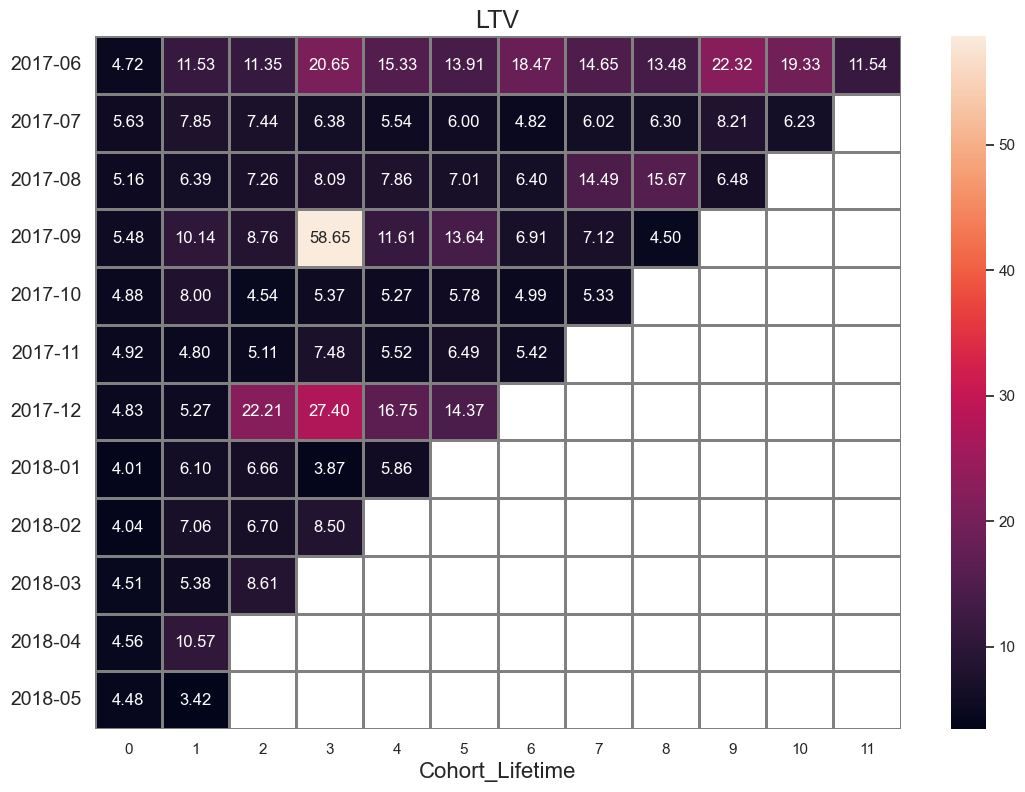

In [52]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV', fontsize=18)
ax = sns.heatmap(ltv.pivot(index='cohort', columns='ts', values='ltv'), annot=True, fmt='.2f', linewidths=1, linecolor='gray')
ax.tick_params(axis='y', rotation=0, labelsize=14)
ax.set_xlabel('Cohort_Lifetime', fontsize=16)
ax.set_ylabel('', fontsize=16)
plt.show()

**Kesimpulan:**

* Dilihat dari tabel cohort, rata-rata LTV pada bulan pertama 4%-5% menuju bulan selanjutnya mengalami peningkatan.
* Pada bulan ke 3, cohort pada bulan 09-2017 mengalami peningkatan LTV hingga 58%.

#### 2.2.3. Marketing Analysis

#### a. Berapa jumlah uang yang dihabiskan? Keseluruhan/per sumber/dari waktu ke waktu?

In [53]:
# Total cost
total_cost = data_costs['costs'].sum()
total_cost

329131.62

In [54]:
# Total cost by source
cost_source = data_costs.groupby(['source_id'])['costs'].sum()
cost_source

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

<Figure size 1000x600 with 0 Axes>

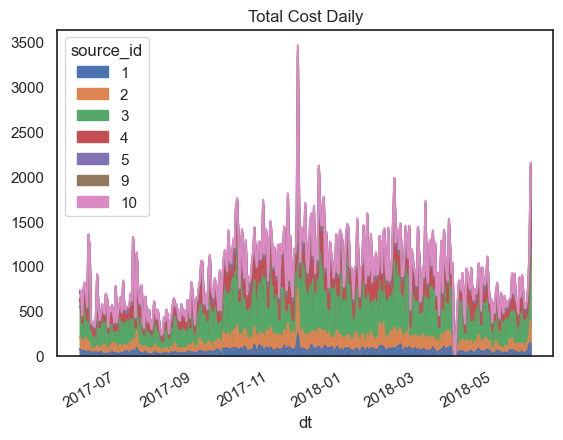

<Figure size 1000x600 with 0 Axes>

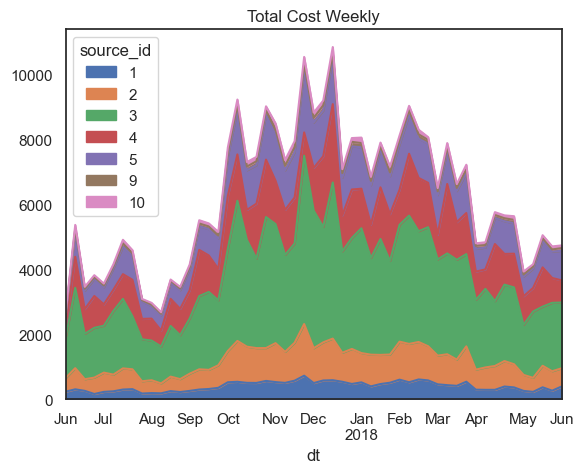

<Figure size 1000x600 with 0 Axes>

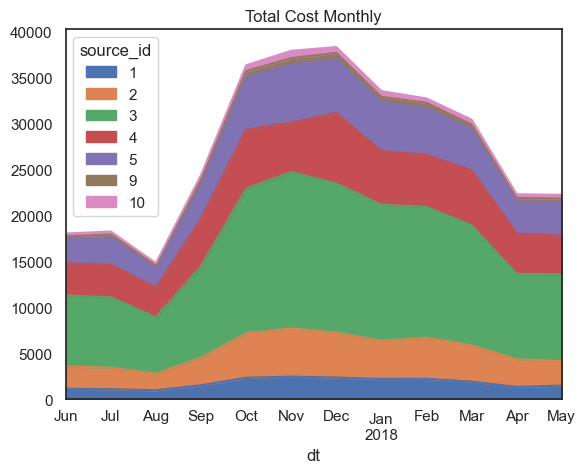

In [55]:
# Total Cost Daily
plt.figure(figsize=(10, 6))
data_costs.groupby(['dt','source_id'])['costs'].sum()\
    .reset_index()\
    .pivot(index='dt',columns='source_id',values='costs')\
    .plot(kind='area',stacked=True)
plt.title('Total Cost Daily')
plt.show()
# Total Cost Weekly
plt.figure(figsize=(10, 6))
data_costs.groupby([data_costs['dt'].dt.to_period('W'),'source_id'])['costs'].sum()\
    .reset_index()\
    .pivot(index='dt',columns='source_id',values='costs')\
    .plot(kind='area',stacked=True)
plt.title('Total Cost Weekly')
plt.show()
# Total Cost Monthly
plt.figure(figsize=(10, 6))
data_costs.groupby([data_costs['dt'].dt.to_period('M'),'source_id'])['costs'].sum()\
    .reset_index()\
    .pivot(index='dt',columns='source_id',values='costs')\
    .plot(kind='area',stacked=True)
plt.title('Total Cost Monthly')
plt.show()

**Kesimpulan:**

* Jumlah uang yang dihabiskan secara keseluruhan adalah 329131. Berdasarkan source_id, sumber 3 memiliki cost tertinggi.

#### b. Berapa biaya akuisisi pelanggan dari masing-masing sumber?

Untuk menemukan biaya akuisisi pelanggan dari masing-masing sumber, Anda perlu mengumpulkan data biaya pemasaran dan jumlah pelanggan yang berhasil didapatkan dari setiap sumber, dan kemudian melakukan perhitungan CAC (Customer Acquisition Cost) untuk masing-masing sumber.

In [56]:
cac = data_orders.merge(data_visits, on=['uid', 'cohort'])

In [57]:
cac_fix = cac.merge(data_costs, left_on=['buy_ts', 'source_id'], right_on=['dt', 'source_id'])

In [58]:
cac_fix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   buy_ts                60 non-null     datetime64[ns]
 1   revenue               60 non-null     float64       
 2   uid                   60 non-null     uint64        
 3   first_order_datetime  60 non-null     datetime64[ns]
 4   orders_month          60 non-null     datetime64[ns]
 5   first_order_month     60 non-null     datetime64[ns]
 6   cohort                60 non-null     period[M]     
 7   year                  60 non-null     int64         
 8   month                 60 non-null     int64         
 9   ts                    60 non-null     int64         
 10  device                60 non-null     category      
 11  end_ts                60 non-null     datetime64[ns]
 12  source_id             60 non-null     int64         
 13  start_ts              

In [59]:
cac_ = cac_fix.groupby('source_id').agg({'costs': 'sum', 'uid': 'count'})

In [60]:
cac_ = cac_.rename(columns={'costs': 'total_cost', 'uid': 'count_user'})
cac_

,total_cost,count_user
source_id,,
1,821.97,10
2,1885.71,12
3,5074.85,14
4,1908.81,12
5,1282.14,9
9,27.80,2
10,21.46,1


In [61]:
cac_['cac'] = cac_['total_cost'] / cac_['count_user']
cac_

,total_cost,count_user,cac
source_id,,,
1,821.97,10,82.197000
2,1885.71,12,157.142500
3,5074.85,14,362.489286
4,1908.81,12,159.067500
5,1282.14,9,142.460000
9,27.80,2,13.900000
10,21.46,1,21.460000


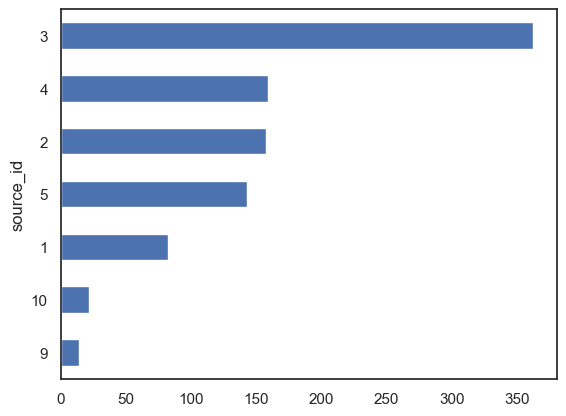

In [62]:
cac_['cac'].sort_values().plot(kind='barh')
plt.show()

**Kesimpulan:**

* Dilihat secara source_id, para pengguna yang membeli produk yang berasal dari source_id 3 memiliki cac tertinggi.

#### c. Seberapa menguntungkannya investasi tersebut?

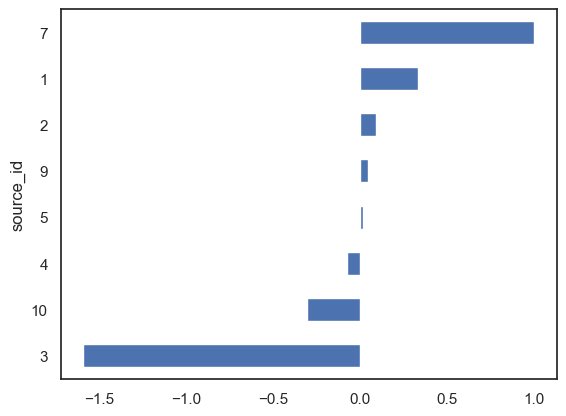

In [63]:
#ROI per marketing channel
roi = pd.DataFrame(pd.DataFrame(data_orders[['uid','revenue']].groupby('uid')['revenue'].sum())\
    .join(pd.DataFrame(data_visits.sort_values(by=['uid','start_ts']).groupby('uid')['source_id'].first()))\
    .groupby('source_id')['revenue'].sum())\
    .join(data_costs.groupby('source_id')['costs'].sum())\
    .fillna(0)
roi['roi'] = (roi['revenue'] - roi['costs'])/roi['revenue']
roi['roi'].sort_values().plot(kind='barh')
plt.show()

**Kesimpulan:**

* Dilihat secara source_id, para pengguna yang membeli produk lebih banyak berasal dari source_id 3. Para investor sepertinya lebih menguntungkan investasi ke sumber tersebut.

## Kesimpulan Umum

#### A. Pra-pemrosesan

Dari eksplorasi pra-pemrosesan data, dapat disimpulkan bahwa:
1. Terdapat 3 data, visit, order, dan cost. 
2. Data visit memiliki kolom nama yang berantakan sehingga perlu dirapihkan. Memory usage telah diturunkan sehingga lebih kecil. Secara keseluruhan tabel visit tidak memiliki nilai hilang dan duplikat.
3. Data order memiliki kolom nama yang berantakan sehingga perlu dirapihkan. Terdapat nilai anomali juga namun tidak terlalu berdampak ke data. Secara keseluruhan tabel visit tidak memiliki nilai hilang dan duplikat.
4. Data cost sudah rapih tidak dilakukan perubahan apapun.

#### B. Analisis Data Esksploratif (EDA)

Dari hasil analisis data esksploratif, dapat disimpulkan bahwa:
1. Dalam analisis produk, jumlah orang yang menggunakan produk rata-rata setiap hari 907, setiap minggu 5716, dan setiap bulan 23228.
2. Dalam analisis produk, jumlah sesi perharinya rata-rata tiap pengguna hanya menggunakan 1 sesi per hari.
3. Dalam analisis produk, durasi setiap sesi per user rata-rata 10 menit, median pengguna yaitu 5 menit. Secara ASL, rata-rata menggunakan produk selama 60 detik.
4. Dalam analisis produk, dalam seminggu pengguna kembali menggunakan produk sebesar 15% dan dalam sebulan yauitu 3%.
5. Dalam analisis sales, user mulai melakukan pembelian dari pertama kali mengunjungi produk adalah 16 menit.
6. Dalam analisis sales, jumlah pesanan yang dibuat selama periode tertentu dibuat dalam bentuk kohort. Dari gambar terlihat bahwa jumlah pelanggan aktif menurun sangat drastis dari bulan pertama. Namun terlihat pula ada beberapa peningkatan jumlah pelanggan aktif di bulan setelahnya.
7. Dalam analisis sales, besaran rata-rata pembeliannya pada bulan pertama sebesar 4%. bulan selanjutnya mengalamin peningkatan pendapatan. Pada cohort 09-2017 di bulan ke 3 mengalami peningkatan hingga 37%
8. Dalam analisis sales, jumlah rata-rata LTV user bulan pertama yaitu 4%-5% dan mengalami peningkatan di bulan selanjutnya. Bahkan pada cohort 09-2017, bulan ketiga mengalami peningkatan LTV hingga 58%.
9. Dalam analisis marketing, jumlah uang yang dihabiskan adalah secara keseluruhan adalah 329131. Secara sumber bervariasi, namun sumber 3 tertinggi.
10. Dalam analisis marketing, biaya akuisisi pelanggan banyak yang berasal dari source_id 3 dengan cac sebesar 362.4.
11. Dalam analisis marketing, pengguna juga banyak yang berasal dar source_id 3, sehingga akan sangat lebih menguntungkan untuk berinvestasi ke sumber tersebut.

